<a href="https://colab.research.google.com/github/nestorbalcazar/nestorbalcazar.github.io/blob/master/NumMethods_ConductionSphere1D_Implicit_Ex00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Fe] N=200: iters=98651, Tmin=383.542, Tmax=425.000
N=200 | L_inf (Fe) = 2.604e-04 K | L2 (Fe) = 2.604e-04 K

Energy balance (Fe BC):
  Q_gen      = 2.094395e+03 W
  Q_conv_num = 2.094395e+03 W
  |Q_gen - Q_conv_num| / Q_gen = 2.188e-11


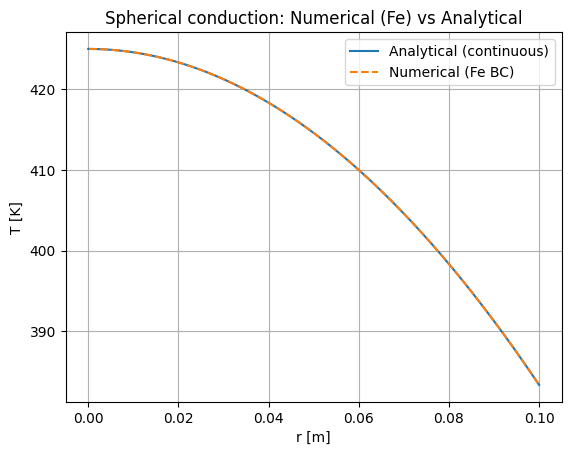

In [4]:
#=======================================================================================
# Numerical Methods in Heat and Mass Transfer
#=======================================================================================
# Support material for Lecture Notes. Prof. Néstor Balcázar-Arciniega
# Updated: 7 October 2025
# --- Spherical radial conduction: FVM + Gauss–Seidel ---
# PDE (steady, λ and qdot constants):
#   0 = (1/r^2) d/dr( λ r^2 dT/dr ) + qdot
# BCs:
#   r = 0   : symmetry (dT/dr = 0)
#   r = Re  : Convection enforced with series resistance at the last control volume:
#             Fe = A_s / ( 1/alpha_G + Δr/λ ), with Δr = (surface - last cell centroid)

import numpy as np
import matplotlib.pyplot as plt

# -------- Physical parameters --------
Re      = 0.10        # [m] sphere radius
lam     = 20.0        # [W/(m·K)] thermal conductivity (constant)
qdot    = 5.0e5       # [W/m^3] volumetric heat generation (constant)
alpha_G = 200.0       # [W/(m^2·K)] external convection coefficient
T_G     = 300.0       # [K] ambient (gas) temperature
A_s     = 4.0*np.pi*Re**2   # sphere surface area

# -------- Analytical solution --------
def T_ana(r):
    # T(r) = T_G + (qdot/(3*alpha_G)) Re + (qdot/(6*lam)) (Re^2 - r^2)
    return T_G + (qdot/(3.0*alpha_G))*Re + (qdot/(6.0*lam))*(Re**2 - r**2)

# -------- Core solver (FVM assembly + GS/SOR) using Fe at the boundary --------
def solve_FVM_Fe(N, omega=1.6, tol=1e-12, itmax=200000, verbose=False):
    """Builds and solves the 1D spherical FVM system with Robin (Fe) boundary at r=Re.
       Distances are centroid-to-centroid; face areas are evaluated at faces."""
    # Mesh: faces and centroids
    r_f = np.linspace(0.0, Re, N+1)             # face radii
    r_c = 0.5*(r_f[:-1] + r_f[1:])              # cell-centroid radii

    # Geometric factors
    Aw  = 4.0*np.pi*(r_f[:-1]**2)               # west-face area for cell i (at r_f[i])
    Ae  = 4.0*np.pi*(r_f[1:]**2)                # east-face area for cell i (at r_f[i+1])
    Vp  = (4.0*np.pi/3.0)*(r_f[1:]**3 - r_f[:-1]**3)  # cell volumes

    # Centroid-to-centroid distances
    dWP = np.zeros(N)           # Δr_WP = r_P - r_W
    dPE = np.zeros(N)           # Δr_PE = r_E - r_P
    dWP[1:]  = r_c[1:] - r_c[:-1]
    dPE[:-1] = r_c[1:] - r_c[:-1]

    # Linear system coefficients: aP*T_P = aE*T_E + aW*T_W + bP
    aW = np.zeros(N); aE = np.zeros(N); aP = np.zeros(N); bP = np.zeros(N)
    SU = qdot * Vp  # source term S_U = qdot * Vp (positive for heating)

    for i in range(N):
        # West diffusion conductance (centroid-to-centroid distance)
        Dw = 0.0 if i == 0 else lam * Aw[i] / (dWP[i] + 1e-300)

        if i == N-1:
            # Robin at outer surface via series resistance:
            # Fe = A_s / (1/alpha_G + Δr/λ), with Δr = (surface - last centroid)
            delta = r_f[-1] - r_c[-1]
            Fe    = A_s / ( (1.0/alpha_G) + (delta/(lam + 1e-300)) )
            aW[i] = Dw
            aE[i] = 0.0
            aP[i] = Dw + Fe
            bP[i] = SU[i] + Fe*T_G
        else:
            # Interior east diffusion conductance (centroid-to-centroid distance)
            De = lam * Ae[i] / (dPE[i] + 1e-300)
            aW[i] = Dw
            aE[i] = De
            aP[i] = Dw + De
            bP[i] = SU[i]

    # Gauss–Seidel Solver
    def gs(aW, aP, aE, bP, T0, omega, tol, itmax):
        T = T0.copy()
        for it in range(itmax):
            Told = T.copy()
            for j in range(N):
                TW = T[j-1] if j > 0   else 0.0
                TE = T[j+1] if j < N-1 else 0.0
                RHS = aE[j]*TE + aW[j]*TW + bP[j]
                T[j] = (1.0-omega)*T[j] + omega * RHS / (aP[j] + 1e-300)
            if np.max(np.abs(T - Told)) < tol:
                return T, it+1
        return T, itmax

    T0 = np.full(N, T_G)
    Tn, iters = gs(aW, aP, aE, bP, T0, omega, tol, itmax)
    if verbose:
        print(f"[Fe] N={N}: iters={iters}, Tmin={Tn.min():.3f}, Tmax={Tn.max():.3f}")
    return r_c, r_f, Tn, iters

# -------- Run one mesh and compare to analytical solution --------
N = 200
r_c, r_f, T_num, iters = solve_FVM_Fe(N, omega=1.6, tol=1e-12, itmax=200000, verbose=True)

# Errors at cell centers
T_ref = T_ana(r_c)
Linf  = np.max(np.abs(T_num - T_ref))
L2    = np.sqrt(np.mean((T_num - T_ref)**2))
print(f"N={N} | L_inf (Fe) = {Linf:.3e} K | L2 (Fe) = {L2:.3e} K")

# -------- Energy balance check (global) --------
V_total = (4.0*np.pi/3.0)*Re**3
Q_gen   = qdot * V_total
# Outgoing heat at surface is exactly Fe * (T_P_last - T_G) in this discrete Robin:
delta_last = r_f[-1] - r_c[-1]
Fe_last    = A_s / ( (1.0/alpha_G) + (delta_last/(lam + 1e-300)) )
Q_conv_num = Fe_last * (T_num[-1] - T_G)

print("\nEnergy balance (Fe BC):")
print(f"  Q_gen      = {Q_gen:.6e} W")
print(f"  Q_conv_num = {Q_conv_num:.6e} W")
print(f"  |Q_gen - Q_conv_num| / Q_gen = {abs(Q_gen - Q_conv_num)/abs(Q_gen):.3e}")

# -------- Plot: analytical vs numerical --------
r_plot = np.linspace(0.0, Re, 400)
plt.figure()
plt.plot(r_plot, T_ana(r_plot), '-', label='Analytical (continuous)')
plt.plot(r_c, T_num, '--', label='Numerical (Fe BC)')
plt.xlabel('r [m]'); plt.ylabel('T [K]')
plt.title('Spherical conduction: Numerical (Fe) vs Analytical')
plt.grid(True); plt.legend()
plt.show()
